In [ ]:
# STAGE1: 对有导管标注的图片进行高亮标注，并且进行训练，这一步训练到准确率为1或者十分接近1

In [1]:
!nvidia-smi

Thu Mar 11 08:35:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Profile

In [4]:
# 以下是四个路径
datadir = 'workspace/competedata_train/'
libdir = 'workspace/'
outputdir = 'workspace/'
otherdir = 'workspace/'

train_bs_ = 16 # train_batch_size
valid_bs_ = 32 # valid_batch_size
num_workers_ = 8

# CFG

In [5]:
class CFG:
    seed=42
    device='GPU' #### ['TPU', 'GPU']
    nprocs=1 # [1, 8] # TPU的核心数，使用GPU时没用
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 # 5折交叉验证
    
    # 标签的列名
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
           'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
    
    n_class=11 # 标签列的数量
    accum_iter=1 # 梯度累积。这里是1，就是不累计
    max_grad_norm=1000  # 梯度裁剪，用来记录到log，看看是否有梯度爆炸的情况
    print_freq=100 # 每个100个iter打印一次log
    normalize_mean=[0.4824, 0.4824, 0.4824] # 本场比赛图像的mean
    normalize_std=[0.22, 0.22, 0.22] # 本场比赛图像的std
    
    suffix="1800"  # 训练的序号，用来记录
    fold_list=[0] # 训练哪几个fold
    epochs=6  
    model_arch="resnet200d" # 模型结构
    img_size=640 # 图片尺寸
    optimizer="Adam" # 优化器
    scheduler="CosineAnnealingLR" # 学习率的调度器
    loss_fn="BCEWithLogitsLoss" # 损失函数
    scheduler_warmup= "GradualWarmupSchedulerV3" # 逐渐升温调度器

    warmup_epo=1 # 逐渐升温调度器参数：通过1个epoch升温
    warmup_factor = 10 # 逐渐升温调度器参数：升温10倍
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # 调度器参数，多少个epoch为一个调度周期
   
    lr=1e-4 # 初始学习率
    min_lr=1e-6 # 最小学习率
    weight_decay=0 # 每个batch学习率衰减参数
    
    fix_mistake = True # 修复错误的标签
    n_early_stopping=3 # 训练早停的耐心值，单位是epoch

# Import

In [6]:
!pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    

import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

     |████████████████████████████████| 122kB 9.6MB/s 
     |████████████████████████████████| 829kB 17.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 163kB 24.2MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 133kB 36.0MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 


# helper

In [7]:
train_df = pd.read_csv(f'{datadir}train.csv')
submission_df = pd.read_csv(f'{datadir}sample_submission.csv')
train_annotations_df = pd.read_csv(f'{datadir}train_annotations.csv')

# 修正错误标签
def fix_mistake_label(train_df, train_annotations_df, ann_index, uid, old_label, correct_label):
    train_df.loc[train_df.StudyInstanceUID==uid, old_label] = 0
    train_df.loc[train_df.StudyInstanceUID==uid, correct_label] = 1
    train_annotations_df.loc[train_annotations_df.index==ann_index, 'label'] = correct_label

if CFG.fix_mistake:
    fix_mistake_csv = pd.read_csv("/content/drive/Shareddrives/xm/ranzcr/archive/fix_mistake0227.csv")
    for row in fix_mistake_csv.values:
        fix_mistake_label(train_df, train_annotations_df, row[0], row[1], row[2], row[3])
    print("Fix Mistake Done!")

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(train_df, train_df[CFG.target_cols], train_df['PatientID'])

https://ui.neptune.ai/syxuming/ranzcr/e/RAN-282
Fix Mistake Done!


In [8]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

# 日志记录函数
def init_logger(log_file=outputdir+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

# Dataset

In [10]:
# 对图片中的导管进行高亮标注
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }

# 构造 dataset类
class TrainDataset(Dataset):
    def __init__(self, df, df_annotations, annot_size=50, transform=None):
        self.df = df
        self.df_annotations = df_annotations
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{datadir}train/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        query_string = f"StudyInstanceUID == '{file_name}'"
        df = self.df_annotations.query(query_string)
        for i, row in df.iterrows():
            label = row["label"]
            data = np.array(ast.literal_eval(row["data"]))
            for d in data:
                image[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                   d[0]-self.annot_size//2:d[0]+self.annot_size//2, :] = COLOR_MAP[label]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

In [11]:
# 图像AUG策略
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
            ])

    elif data == 'light_train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ])


    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


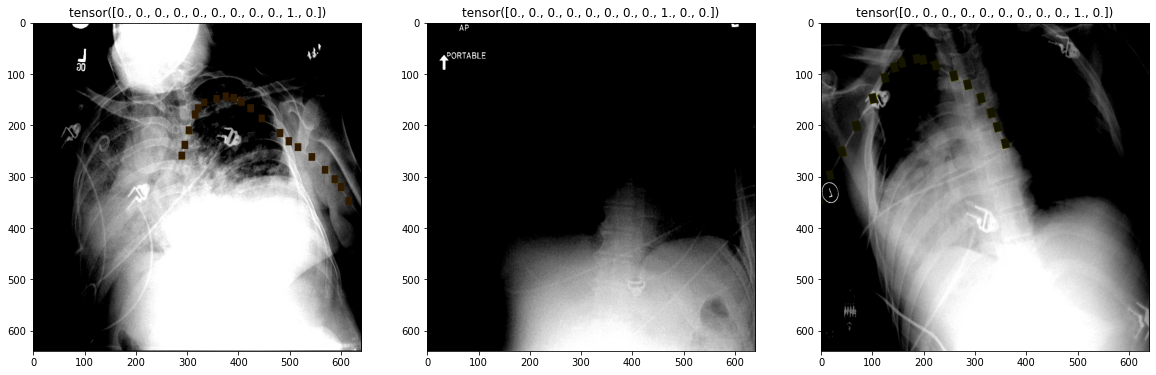

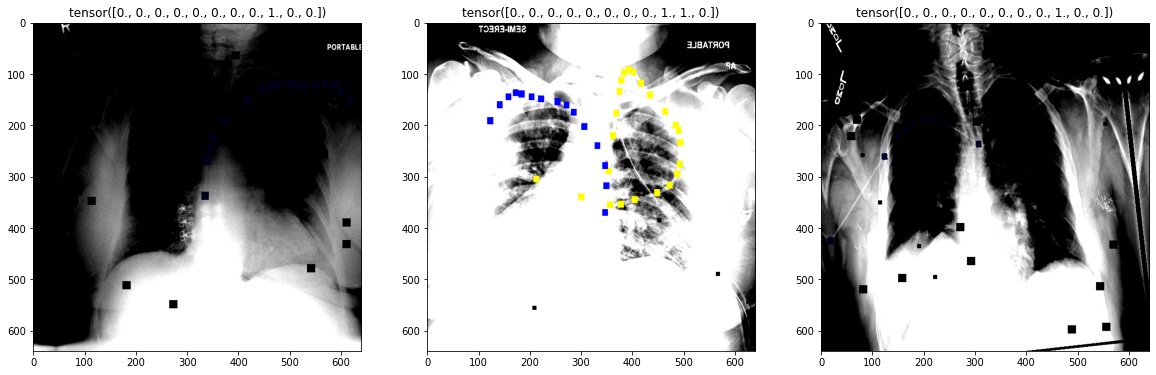

In [12]:
# 图像示例
from pylab import rcParams
dataset_show = TrainDataset(train_df[train_df["StudyInstanceUID"].isin(train_annotations_df['StudyInstanceUID'].unique())].reset_index(drop=True),
               train_annotations_df,
               transform=get_transforms("light_train") # None, get_transforms("train")
               )
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [13]:
# 构造模型
class RanzcrClassifier(nn.Module):
    def __init__(self, model_arch, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.n_class)
        elif "resnet" in CFG.model_arch:
            n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(n_features, CFG.n_class)

    def forward(self, x):
        if 'efficientnet' in CFG.model_arch:
            return self.model(x)
        elif "resnet" in CFG.model_arch:
            bs = x.size(0)
            features = self.model(x)
            pooled_features = self.pooling(features).view(bs, -1)
            output = self.fc(pooled_features)
            return features, pooled_features, output

In [14]:
# 每个epoch的训练部分
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [15]:
# 每个epoch的valid部分
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# loss & optimizer & scheduler

In [16]:
# 自定义逐渐升温调度器
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [17]:
# 训练函数
def train_loop(df, fold, trn_idx, val_idx):
    loginfo(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader 载入数据
    # ====================================================
    train_folds = train_df.loc[trn_idx].reset_index(drop=True)
    valid_folds = train_df.loc[val_idx].reset_index(drop=True)

    train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations_df['StudyInstanceUID'].unique())].reset_index(drop=True)
    valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annotations_df['StudyInstanceUID'].unique())].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, train_annotations_df, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, train_annotations_df, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss  载入模型、优化器、调度器和损失函数
    # ====================================================
    
    model = RanzcrClassifier(CFG.model_arch, pretrained=False).to(device)

    # optimizer
    if CFG.optimizer == "Adam":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)  
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV2":
        scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)
    elif CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    if CFG.loss_fn == "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss()

    # ====================================================
    # loop # 开始每个epoch循环
    # ====================================================

    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    best_acc_epoch=0;
    
    
    for epoch in range(CFG.epochs):
        # 查看并记录当前的lr
        loginfo(f"***** Epoch {epoch} *****")
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")
                
        start_time = time.time() # 记录当前时间

        # train
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_train_loader = pl.ParallelLoader(train_loader, [device])
            avg_loss, cur_lr = train_one_epoch(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # valid
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            avg_val_loss, preds, valid_labels = valid_one_epoch(para_valid_loader.per_device_loader(device), model, criterion, device)
            preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
            valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else:
            avg_val_loss, preds, _ = valid_one_epoch(valid_loader, model, criterion, device)

        # scoring
        score, scores = get_score(valid_labels, preds)
        elapsed = time.time() - start_time
        
        # 日志记录
        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        
        # 使用调度器对lr进行迭代
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict(), 'preds': preds}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict(), 'preds': preds}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

        # early stopping 
        if score > valid_acc_max:
            valid_acc_max = score
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1

        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            valid_loss_min_cnt=0
        else:
            valid_loss_min_cnt+=1

        if valid_acc_max_cnt >= CFG.n_early_stopping and valid_loss_min_cnt >= CFG.n_early_stopping:
            cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break
        
        # 保存当前epoch模型
        cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

    check_point = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [18]:
def main():
    oof_df = pd.DataFrame()
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold in CFG.fold_list:
            _oof_df = train_loop(train_df, fold, trn_idx, val_idx)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
                
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(outputdir+f'oof_df{CFG.suffix}.csv', index=False)

# Main

In [19]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


1115


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:1e-05
scheduler_last_epoch:0, scheduler_lr:1e-05
optimizer_lr:1e-05


Epoch: [0][0/600] Data 1.859 (1.859) Elapsed 0m 4s (remain 46m 37s) Loss: 0.7016(0.7016) Grad: 57872.8359  LR: 0.0000100  
Epoch: [0][100/600] Data 0.596 (0.331) Elapsed 1m 30s (remain 7m 25s) Loss: 0.5391(0.6215) Grad: 51174.8047  LR: 0.0000100  
Epoch: [0][200/600] Data 0.116 (0.329) Elapsed 2m 56s (remain 5m 50s) Loss: 0.3740(0.5405) Grad: 39183.0430  LR: 0.0000100  
Epoch: [0][300/600] Data 0.601 (0.330) Elapsed 4m 23s (remain 4m 22s) Loss: 0.2481(0.4655) Grad: 35360.5352  LR: 0.0000100  
Epoch: [0][400/600] Data 0.529 (0.326) Elapsed 5m 48s (remain 2m 52s) Loss: 0.2251(0.4108) Grad: 33488.2539  LR: 0.0000100  
Epoch: [0][500/600] Data 0.568 (0.319) Elapsed 7m 11s (remain 1m 25s) Loss: 0.1972(0.3685) Grad: 32497.1230  LR: 0.0000100  
Epoch: [0][599/600] Data 0.000 (0.313) Elapsed 8m 32s (remain 0m 0s) Loss: 0.1437(0.3360) Grad: 24847.9922  LR: 0.0000100  
EVAL: [0/64] Data 3.496 (3.496) Elapsed 0m 5s (remain 5m 35s) Loss: 0.1203(0.1203) 
EVAL: [63/64] Data 0.000 (1.265) Elapsed 1m 

Epoch 0 - avg_train_loss: 0.3360  avg_val_loss: 0.1485  time: 619s
Epoch 0 - Score: 0.9020  Scores: [0.6128 0.8256 0.8855 0.8854 0.926  0.9996 0.9999 0.9747 0.98   0.9785
 0.8538]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:0.0001
scheduler_last_epoch:0, scheduler_lr:1e-05
optimizer_lr:0.0001


Epoch: [1][0/600] Data 1.532 (1.532) Elapsed 0m 2s (remain 20m 45s) Loss: 0.1419(0.1419) Grad: 27956.6895  LR: 0.0001000  
Epoch: [1][100/600] Data 0.276 (0.262) Elapsed 1m 20s (remain 6m 37s) Loss: 0.0902(0.1119) Grad: 28264.9258  LR: 0.0001000  
Epoch: [1][200/600] Data 0.150 (0.251) Elapsed 2m 38s (remain 5m 13s) Loss: 0.0552(0.0904) Grad: 20468.4805  LR: 0.0001000  
Epoch: [1][300/600] Data 0.000 (0.252) Elapsed 3m 56s (remain 3m 55s) Loss: 0.0121(0.0769) Grad: 10036.2363  LR: 0.0001000  
Epoch: [1][400/600] Data 0.000 (0.256) Elapsed 5m 17s (remain 2m 37s) Loss: 0.0331(0.0658) Grad: 27742.0410  LR: 0.0001000  
Epoch: [1][500/600] Data 0.000 (0.262) Elapsed 6m 40s (remain 1m 19s) Loss: 0.0084(0.0587) Grad: 7885.2402  LR: 0.0001000  
Epoch: [1][599/600] Data 0.270 (0.267) Elapsed 8m 2s (remain 0m 0s) Loss: 0.0332(0.0519) Grad: 54817.3047  LR: 0.0001000  
EVAL: [0/64] Data 3.601 (3.601) Elapsed 0m 3s (remain 4m 10s) Loss: 0.0100(0.0100) 


Epoch 1 - avg_train_loss: 0.0519  avg_val_loss: 0.0159  time: 594s
Epoch 1 - Score: 0.9834  Scores: [0.8271 0.9997 0.9997 1.     1.     0.9998 1.     0.9934 0.9988 0.9994
 1.    ]


EVAL: [63/64] Data 0.000 (1.372) Elapsed 1m 51s (remain 0m 0s) Loss: 0.0030(0.0159) 


***** Epoch 2 *****
schwarmup_last_epoch:1, schwarmup_lr:8.55017856687341e-05
scheduler_last_epoch:1, scheduler_lr:8.55017856687341e-05
optimizer_lr:8.55017856687341e-05


Epoch: [2][0/600] Data 1.644 (1.644) Elapsed 0m 2s (remain 21m 41s) Loss: 0.0310(0.0310) Grad: 38925.2031  LR: 0.0000855  
Epoch: [2][100/600] Data 0.707 (0.318) Elapsed 1m 26s (remain 7m 7s) Loss: 0.0007(0.0125) Grad: 772.7001  LR: 0.0000855  
Epoch: [2][200/600] Data 0.000 (0.311) Elapsed 2m 50s (remain 5m 38s) Loss: 0.0075(0.0137) Grad: 10690.3584  LR: 0.0000855  
Epoch: [2][300/600] Data 0.000 (0.311) Elapsed 4m 15s (remain 4m 14s) Loss: 0.0009(0.0128) Grad: 1058.8752  LR: 0.0000855  
Epoch: [2][400/600] Data 0.000 (0.313) Elapsed 5m 40s (remain 2m 49s) Loss: 0.0040(0.0124) Grad: 18631.2461  LR: 0.0000855  
Epoch: [2][500/600] Data 0.000 (0.311) Elapsed 7m 5s (remain 1m 24s) Loss: 0.0306(0.0116) Grad: 37358.2383  LR: 0.0000855  
Epoch: [2][599/600] Data 0.267 (0.310) Elapsed 8m 29s (remain 0m 0s) Loss: 0.0008(0.0115) Grad: 1237.6046  LR: 0.0000855  
EVAL: [0/64] Data 3.512 (3.512) Elapsed 0m 3s (remain 4m 5s) Loss: 0.0017(0.0017) 


Epoch 2 - avg_train_loss: 0.0115  avg_val_loss: 0.0062  time: 622s
Epoch 2 - Score: 0.9995  Scores: [0.9966 1.     0.9987 1.     1.     1.     1.     1.     0.9999 0.9994
 1.    ]


EVAL: [63/64] Data 0.000 (1.393) Elapsed 1m 52s (remain 0m 0s) Loss: 0.0003(0.0062) 


***** Epoch 3 *****
schwarmup_last_epoch:1, schwarmup_lr:5.05e-05
scheduler_last_epoch:2, scheduler_lr:5.05e-05
optimizer_lr:5.05e-05


Epoch: [3][0/600] Data 1.684 (1.684) Elapsed 0m 2s (remain 22m 16s) Loss: 0.0004(0.0004) Grad: 755.1221  LR: 0.0000505  
Epoch: [3][100/600] Data 0.543 (0.330) Elapsed 1m 28s (remain 7m 14s) Loss: 0.0004(0.0047) Grad: 569.3672  LR: 0.0000505  
Epoch: [3][200/600] Data 0.639 (0.321) Elapsed 2m 52s (remain 5m 42s) Loss: 0.0002(0.0048) Grad: 240.4788  LR: 0.0000505  
Epoch: [3][300/600] Data 0.238 (0.320) Elapsed 4m 18s (remain 4m 16s) Loss: 0.0007(0.0051) Grad: 1827.6670  LR: 0.0000505  
Epoch: [3][400/600] Data 0.805 (0.319) Elapsed 5m 43s (remain 2m 50s) Loss: 0.0003(0.0051) Grad: 993.4435  LR: 0.0000505  
Epoch: [3][500/600] Data 0.150 (0.319) Elapsed 7m 9s (remain 1m 24s) Loss: 0.0002(0.0060) Grad: 321.8713  LR: 0.0000505  
Epoch: [3][599/600] Data 0.000 (0.320) Elapsed 8m 34s (remain 0m 0s) Loss: 0.0003(0.0058) Grad: 1276.7635  LR: 0.0000505  
EVAL: [0/64] Data 3.536 (3.536) Elapsed 0m 3s (remain 4m 6s) Loss: 0.0003(0.0003) 


Epoch 3 - avg_train_loss: 0.0058  avg_val_loss: 0.0176  time: 628s
Epoch 3 - Score: 0.9982  Scores: [0.9997 1.     0.9924 1.     1.     1.     1.     0.995  0.9965 0.997
 1.    ]


EVAL: [63/64] Data 0.000 (1.400) Elapsed 1m 53s (remain 0m 0s) Loss: 0.0071(0.0176) 


***** Epoch 4 *****
schwarmup_last_epoch:1, schwarmup_lr:1.54982143312659e-05
scheduler_last_epoch:3, scheduler_lr:1.54982143312659e-05
optimizer_lr:1.54982143312659e-05


Epoch: [4][0/600] Data 1.608 (1.608) Elapsed 0m 2s (remain 22m 1s) Loss: 0.0004(0.0004) Grad: 1279.3993  LR: 0.0000155  
Epoch: [4][100/600] Data 0.006 (0.324) Elapsed 1m 27s (remain 7m 12s) Loss: 0.0002(0.0071) Grad: 292.8429  LR: 0.0000155  
Epoch: [4][200/600] Data 0.011 (0.324) Elapsed 2m 53s (remain 5m 44s) Loss: 0.0001(0.0063) Grad: 233.3709  LR: 0.0000155  
Epoch: [4][300/600] Data 0.007 (0.322) Elapsed 4m 18s (remain 4m 17s) Loss: 0.0001(0.0055) Grad: 53.8992  LR: 0.0000155  
Epoch: [4][400/600] Data 0.000 (0.319) Elapsed 5m 44s (remain 2m 50s) Loss: 0.0006(0.0050) Grad: 2695.5149  LR: 0.0000155  
Epoch: [4][500/600] Data 0.558 (0.318) Elapsed 7m 9s (remain 1m 24s) Loss: 0.0003(0.0046) Grad: 2068.3140  LR: 0.0000155  
Epoch: [4][599/600] Data 0.000 (0.318) Elapsed 8m 33s (remain 0m 0s) Loss: 0.0004(0.0043) Grad: 1033.1449  LR: 0.0000155  
EVAL: [0/64] Data 3.508 (3.508) Elapsed 0m 3s (remain 4m 5s) Loss: 0.0001(0.0001) 


Epoch 4 - avg_train_loss: 0.0043  avg_val_loss: 0.0026  time: 627s
Epoch 4 - Score: 1.0000  Scores: [0.9997 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.    ]


EVAL: [63/64] Data 0.000 (1.397) Elapsed 1m 52s (remain 0m 0s) Loss: 0.0001(0.0026) 


***** Epoch 5 *****
schwarmup_last_epoch:1, schwarmup_lr:1e-06
scheduler_last_epoch:4, scheduler_lr:1e-06
optimizer_lr:1e-06


Epoch: [5][0/600] Data 1.735 (1.735) Elapsed 0m 2s (remain 22m 47s) Loss: 0.0004(0.0004) Grad: 713.9275  LR: 0.0000010  
Epoch: [5][100/600] Data 0.528 (0.346) Elapsed 1m 28s (remain 7m 17s) Loss: 0.0002(0.0040) Grad: 457.6433  LR: 0.0000010  
Epoch: [5][200/600] Data 0.181 (0.329) Elapsed 2m 53s (remain 5m 44s) Loss: 0.0008(0.0048) Grad: 1127.3328  LR: 0.0000010  
Epoch: [5][300/600] Data 0.000 (0.321) Elapsed 4m 17s (remain 4m 16s) Loss: 0.0001(0.0039) Grad: 237.6834  LR: 0.0000010  
Epoch: [5][400/600] Data 0.000 (0.320) Elapsed 5m 43s (remain 2m 50s) Loss: 0.0008(0.0041) Grad: 673.2841  LR: 0.0000010  
Epoch: [5][500/600] Data 0.006 (0.319) Elapsed 7m 9s (remain 1m 24s) Loss: 0.0466(0.0040) Grad: 10249.4717  LR: 0.0000010  
Epoch: [5][599/600] Data 0.265 (0.318) Elapsed 8m 33s (remain 0m 0s) Loss: 0.0002(0.0040) Grad: 125.5093  LR: 0.0000010  
EVAL: [0/64] Data 3.577 (3.577) Elapsed 0m 3s (remain 4m 9s) Loss: 0.0001(0.0001) 


Epoch 5 - avg_train_loss: 0.0040  avg_val_loss: 0.0114  time: 626s
Epoch 5 - Score: 0.9990  Scores: [0.9997 0.9998 0.9958 1.     1.     1.     1.     0.9987 0.9981 0.997
 1.    ]


EVAL: [63/64] Data 0.000 (1.398) Elapsed 1m 53s (remain 0m 0s) Loss: 0.0001(0.0114) 


========== fold: 0 result ==========
Score: 1.0000  Scores: [0.9997 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.    ]
========== CV ==========
Score: 1.0000  Scores: [0.9997 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.    ]


In [20]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}_cpu.pth')